In [115]:
print('Hello, world!')

Hello, world!


In [116]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow import keras

In [117]:
print(tf.__version__)

2.3.1


In [219]:
import pathlib

path = 'USTC_SmokeRStrain'
data_dir = pathlib.Path(path)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

5603


In [220]:
batch_size = 64
img_height = 64
img_width = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  batch_size = batch_size,
  image_size=(img_height, img_width))

Found 5603 files belonging to 6 classes.
Using 4483 files for training.


In [221]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 5603 files belonging to 6 classes.
Using 1120 files for validation.


In [203]:
class_names = train_ds.class_names
print(class_names)

['Cloud', 'Dust', 'Haze', 'Land', 'Seaside', 'Smoke']


0.0 0.9794118


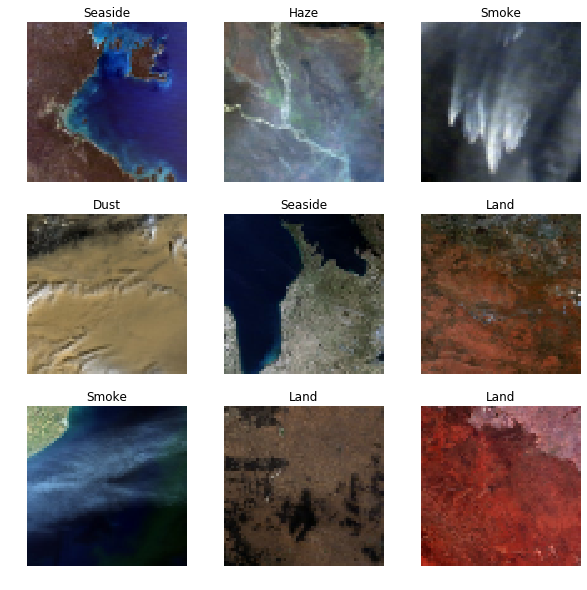

In [204]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds_normal = train_ds.map(process)
val_ds_normal = val_ds.map(process)

image_batch, labels_batch = next(iter(train_ds_normal))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

In [205]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds_normal = train_ds_normal.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_normal = val_ds_normal.cache().prefetch(buffer_size=AUTOTUNE)

In [164]:
num_classes = 6

model = tf.keras.Sequential([
  #tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['sparse_categorical_accuracy'])

model.fit(
  train_ds_normal,
  validation_data=val_ds_normal,
  epochs=8
)

Epoch 1/8
141/141 [==============================] - 21s 150ms/step - loss: 1.2201 - sparse_categorical_accuracy: 0.5235 - val_sparse_categorical_accuracy: 0.4848 - val_loss: 1.2660
Epoch 2/8
141/141 [==============================] - 21s 150ms/step - loss: 0.8889 - sparse_categorical_accuracy: 0.6629 - val_sparse_categorical_accuracy: 0.5518 - val_loss: 1.1763
Epoch 3/8
141/141 [==============================] - 21s 148ms/step - loss: 0.8110 - sparse_categorical_accuracy: 0.6882 - val_sparse_categorical_accuracy: 0.6143 - val_loss: 1.0236
Epoch 4/8
141/141 [==============================] - 20s 142ms/step - loss: 0.7618 - sparse_categorical_accuracy: 0.7080 - val_sparse_categorical_accuracy: 0.6804 - val_loss: 0.8606
Epoch 5/8
141/141 [==============================] - 21s 149ms/step - loss: 0.7042 - sparse_categorical_accuracy: 0.7337 - val_sparse_categorical_accuracy: 0.7134 - val_loss: 0.7772
Epoch 6/8
141/141 [==============================] - 20s 142ms/step - loss: 0.6611 - spars

In [165]:
model.save('MODEL')
model.save('model.h5')
model.evaluate(val_ds_normal, verbose=2)

INFO:tensorflow:Assets written to: MODEL\assets
35/35 - 1s - loss: 0.6723 - sparse_categorical_accuracy: 0.7580


[0.6723076105117798, 0.7580357193946838]

In [166]:
restored = tf.keras.models.load_model('MODEL')
restored2 = tf.keras.models.load_model('model.h5')
restored.evaluate(val_ds_normal, verbose=2)
restored2.evaluate(val_ds_normal, verbose=2)

35/35 - 1s - loss: 0.6723 - sparse_categorical_accuracy: 0.7580
35/35 - 1s - loss: 0.6723 - sparse_categorical_accuracy: 0.7580


[0.6723076105117798, 0.7580357193946838]

In [206]:
resnetSmoke = tf.keras.models.load_model('resnet.h5')
resnetSmoke.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['sparse_categorical_accuracy'])

In [207]:
resnetSmoke.evaluate(val_ds_normal, verbose=2)

18/18 - 18s - loss: 1.0993 - sparse_categorical_accuracy: 0.9455


[1.0992980003356934, 0.9455357193946838]

In [208]:
resnetSmoke.load_weights("accurate/cp")

In [177]:
resnetSmoke.fit(
  train_ds_normal,
  epochs=5
)

Epoch 1/5
 14/141 [=>............................] - ETA: 5:58 - loss: 1.0628 - sparse_categorical_accuracy: 0.9821

KeyboardInterrupt: 

In [209]:
resnetSmoke.evaluate(val_ds_normal, verbose=2)

18/18 - 18s - loss: 1.0535 - sparse_categorical_accuracy: 0.9902


[1.0535224676132202, 0.9901785850524902]

In [170]:
resnetSmoke.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [210]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
resnet = ResNet50(include_top=False, weights= 'imagenet', input_shape=(64,64,3))

In [211]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [212]:
x = resnet.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.7)(x)
predictions = tf.keras.layers.Dense(num_classes, activation= 'softmax')(x)

for layer in resnet.layers:
    layer.trainable = False

final_model = Model(inputs = resnet.input, outputs = predictions)

In [213]:
final_model.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________

In [214]:
final_model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['sparse_categorical_accuracy'])

final_model.fit(
  train_ds_normal,
  epochs=10
)

for layer in resnet.layers:
    layer.trainable = True

Epoch 1/10
71/71 [==============================] - 76s 1s/step - loss: 1.7971 - sparse_categorical_accuracy: 0.1673
Epoch 2/10
71/71 [==============================] - 74s 1s/step - loss: 1.7880 - sparse_categorical_accuracy: 0.2017
Epoch 3/10
71/71 [==============================] - 74s 1s/step - loss: 1.7816 - sparse_categorical_accuracy: 0.2137
Epoch 4/10
71/71 [==============================] - 74s 1s/step - loss: 1.7743 - sparse_categorical_accuracy: 0.2260
Epoch 5/10
71/71 [==============================] - 73s 1s/step - loss: 1.7706 - sparse_categorical_accuracy: 0.2347
Epoch 6/10
71/71 [==============================] - 73s 1s/step - loss: 1.7681 - sparse_categorical_accuracy: 0.2356
Epoch 7/10
71/71 [==============================] - 73s 1s/step - loss: 1.7637 - sparse_categorical_accuracy: 0.2445
Epoch 8/10
71/71 [==============================] - 73s 1s/step - loss: 1.7608 - sparse_categorical_accuracy: 0.2496
Epoch 9/10
71/71 [==============================] - 74s 1s/step 

In [215]:
final_model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['sparse_categorical_accuracy'])

final_model.fit(
  train_ds_normal,
  epochs=30
)

Epoch 1/30
71/71 [==============================] - 386s 5s/step - loss: 1.4098 - sparse_categorical_accuracy: 0.6326
Epoch 2/30
71/71 [==============================] - 383s 5s/step - loss: 1.3172 - sparse_categorical_accuracy: 0.7263
Epoch 3/30
71/71 [==============================] - 365s 5s/step - loss: 1.3180 - sparse_categorical_accuracy: 0.7250
Epoch 4/30
71/71 [==============================] - 372s 5s/step - loss: 1.3187 - sparse_categorical_accuracy: 0.7256
Epoch 5/30
71/71 [==============================] - 379s 5s/step - loss: 1.3453 - sparse_categorical_accuracy: 0.6980
Epoch 6/30
71/71 [==============================] - 422s 6s/step - loss: 1.3691 - sparse_categorical_accuracy: 0.6725
Epoch 7/30
71/71 [==============================] - 402s 6s/step - loss: 1.2880 - sparse_categorical_accuracy: 0.7542
Epoch 8/30
71/71 [==============================] - 366s 5s/step - loss: 1.2845 - sparse_categorical_accuracy: 0.7598
Epoch 9/30
71/71 [==============================] - 365s

In [216]:
for layer in resnet.layers:
    layer.trainable = True
    
final_model = Model(inputs = resnet.input, outputs = predictions)
final_model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['sparse_categorical_accuracy'])

final_model.fit(
  train_ds_normal,
  epochs=30
)

Epoch 1/30
71/71 [==============================] - 364s 5s/step - loss: 1.2140 - sparse_categorical_accuracy: 0.8287
Epoch 2/30
71/71 [==============================] - 365s 5s/step - loss: 1.1916 - sparse_categorical_accuracy: 0.8517
Epoch 3/30
71/71 [==============================] - 364s 5s/step - loss: 1.2052 - sparse_categorical_accuracy: 0.8372
Epoch 4/30
71/71 [==============================] - 364s 5s/step - loss: 1.2183 - sparse_categorical_accuracy: 0.8244
Epoch 5/30
71/71 [==============================] - 364s 5s/step - loss: 1.2078 - sparse_categorical_accuracy: 0.8354
Epoch 6/30
71/71 [==============================] - 364s 5s/step - loss: 1.1678 - sparse_categorical_accuracy: 0.8751
Epoch 7/30
71/71 [==============================] - 366s 5s/step - loss: 1.1647 - sparse_categorical_accuracy: 0.8778
Epoch 8/30
71/71 [==============================] - 365s 5s/step - loss: 1.1701 - sparse_categorical_accuracy: 0.8744
Epoch 9/30
71/71 [==============================] - 365s

In [217]:
final_model.evaluate(val_ds_normal, verbose=2)

18/18 - 18s - loss: 1.2594 - sparse_categorical_accuracy: 0.7830


[1.2594014406204224, 0.7830356955528259]

In [218]:
final_model.save('resnetBEST2.h5')

In [155]:
new_model = tf.keras.models.load_model('resnetRooms')

In [158]:
new_model.evaluate(val_ds_normal, verbose=2)

35/35 - 23s - loss: 1.7617 - accuracy: 0.1268


[1.7616589069366455, 0.12678571045398712]